In [1]:
from cfdmod.use_cases.hfpi import solver, handler, analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib

analysis.set_plt_style()

### Report directory
base_base = pathlib.Path("/mnt/disk01/prd-eng/portfolio-eng/simulation_files/petra_nova_fluidmechanics/comparison/dynamic_analysis")
subproject_path = base_base / "subproj_main"
structure_path = base_base / "struct_original"
case_path = subproject_path / "out"
data_path = subproject_path / "forces/"

base_folder = pathlib.Path("/mnt/disk01/prd-eng/cases/petra_nova_fluidmechanics/engmod_case")
experimental_data_path = base_folder / "../comparison/force_by_floor/exp_csv/"



In [2]:
### building dimensions
H = 250.424
Bx = 69.14
By = 90.6
B = max(Bx, By)

dimensions = handler.DimensionSpecs(base=B, height=H)

In [3]:
modes_csv = structure_path / "modes.csv"

n_modes = 12
floors_csv = structure_path / "nodes.csv"
phi_csvs = [structure_path / f"phi_{i}.csv" for i in range(1, n_modes+1)]

struct_data = solver.HFPIStructuralData.build(
    modes_csv=modes_csv,
    floors_csv=floors_csv,
    phi_floors_csvs=phi_csvs,
    max_active_modes=5,
)

In [4]:
directions = ["000", "030", "060", "090", "120", "150", "180", "210", "240", "270", "300", "330"]
directions = ["000"]
float_directions = [float(d) for d in directions]
recurrence_periods = [1, 10, 50]
xis = [0.01, 0.02]

In [5]:
directional_forces = {}

for d in directions:
    cf_x_h5 = data_path / f"FX_{d}.h5"
    cf_y_h5 = data_path / f"FY_{d}.h5"
    cm_z_h5 = data_path / f"MZ_{d}.h5"
    forces_data = solver.HFPIForcesData.build(cf_x_h5, cf_y_h5, cm_z_h5)
    directional_forces[float(d)] = forces_data

directional_forces.keys()

dict_keys([0.0])

In [6]:
wind_analytical = handler.WindAnalysis(
    directional_velocity_multiplier={d: 1 for d in float_directions},
    directional_roughness_cats=pd.DataFrame(),
)

In [7]:
results_save = pathlib.Path("/mnt/dev01_fs_shared/waine/repos/cfdmod/output/hfpi_test")
analysis_full = handler.HFPIAnalysisHandler(
    wind_analytics=wind_analytical,
    dimensions=dimensions,
    structural_data=struct_data,
    directional_forces=directional_forces,
    save_folder=results_save,
)

In [8]:
all_parameters = analysis_full.generate_combined_parameters(
    directions=float_directions,
    recurrence_periods=recurrence_periods,
    xis=xis,
)


In [9]:
results = handler.HFPIFullResults.load_all_results(results_folder=results_save, parameters=all_parameters)


In [10]:
max_acceleration = results.filter_by_xi(xi=0.01).get_max_acceleration_by_recurrence_period()

max_acceleration

{1.0: np.float64(1.6701925579261132),
 10.0: np.float64(1.6701925579261132),
 50.0: np.float64(1.6701925579261132)}

In [11]:
results_use = results.filter_by_xi(0.01).filter_by_recurrence_period(50)

peaks = results_use.get_global_peaks_by_direction()
peaks

{'forces_static':    direction         min_x         min_y         min_z         max_x  \
 0        0.0  58635.030293 -3.001204e+07  2.523949e+08  1.217909e+07   
 
           max_y         max_z        mean_x        mean_y        mean_z  
 0 -9.569276e+06  7.614236e+08  5.243778e+06 -1.807239e+07  4.604945e+08  ,
 'moments_static':    direction         min_x         min_y         min_z         max_x  \
 0        0.0 -3.273369e+07 -3.065425e+09  2.523949e+08  1.410424e+09   
 
           max_y         max_z        mean_x        mean_y        mean_z  
 0 -8.970971e+08  7.614236e+08  6.056521e+08 -1.799981e+09  4.604945e+08  ,
 'forces_static_eq':    direction         min_x         min_y         min_z         max_x  \
 0        0.0 -5.645067e+07 -2.737012e+08 -4.744234e+07  7.764443e+07   
 
           max_y         max_z        mean_x        mean_y        mean_z  
 0  2.513674e+07  3.928036e+07  1.213746e+07 -1.047267e+08 -5.130986e+06  ,
 'moments_static_eq':    direction         min_x

In [12]:
peaks["forces_static_eq"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,-5.645067e+07,-2.737012e+08,-4.744234e+07,7.764443e+07,2.513674e+07,3.928036e+07,1.213746e+07,-1.047267e+08,-5.130986e+06


In [13]:
peaks["forces_static"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,58635.030293,-3.001204e+07,2.523949e+08,1.217909e+07,-9.569276e+06,7.614236e+08,5.243778e+06,-1.807239e+07,4.604945e+08


39280362.5432578 761423572.1484375
-47442337.21126439 252394934.5546875


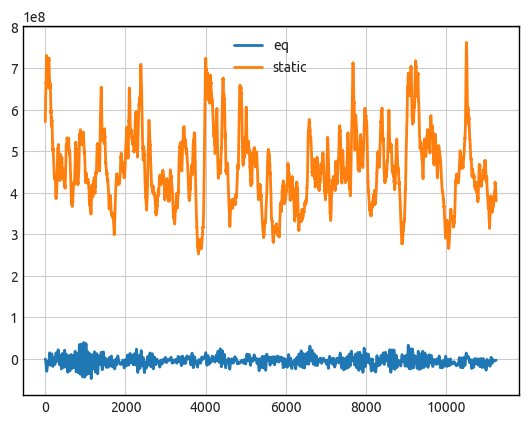

In [17]:
res_0 = list(results_use.results.values())[0]
d = "z"

plt.plot(
    res_0.global_moments_static_eq[d], label="eq"
)
plt.plot(
    res_0.static_results.global_moments_static[d], label="static"
)
plt.legend()
print(max(res_0.global_moments_static_eq[d]), max(res_0.static_results.global_moments_static[d]))
print(min(res_0.global_moments_static_eq[d]), min(res_0.static_results.global_moments_static[d]))